In [163]:
import pandas as pd

# reading cleaned data
data = pd.read_csv('./classification_data_cleaned.csv')

print("Data shape : ", data.shape)

Data shape :  (4024, 16)


In [164]:
# drop target variables
x = data.drop(columns=["Mortality_Status"])
y = data["Mortality_Status"]

In [165]:
print("Features used for classification:")
for col in x.columns:
    print(col)

print("Shape of x (features):", x.shape)
print("Shape of y (target):", y.shape)


Features used for classification:
Age
6th_Stage
Differentiated
Grade
A_Stage
Tumor_Size
Regional_Node_Examined
Reginol_Node_Positive
T_Stage_T2
T_Stage_T3
T_Stage_T4
N_Stage_N2
N_Stage_N3
Estrogen_Status_Positive
Progesterone_Status_Positive
Shape of x (features): (4024, 15)
Shape of y (target): (4024,)


In [166]:
from sklearn.model_selection import train_test_split

# split 80% for trainning , 20% for testing
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, stratify=y, random_state=42
)

print("------- Classification data split complete -------")
print(f"Training set: {x_train.shape[0]} samples")
print(f"Testing set: {x_test.shape[0]} samples")

------- Classification data split complete -------
Training set: 2816 samples
Testing set: 1208 samples


In [167]:

print(x_train.dtypes)


Age                             float64
6th_Stage                        object
Differentiated                   object
Grade                             int64
A_Stage                          object
Tumor_Size                      float64
Regional_Node_Examined          float64
Reginol_Node_Positive             int64
T_Stage_T2                         bool
T_Stage_T3                         bool
T_Stage_T4                         bool
N_Stage_N2                         bool
N_Stage_N3                         bool
Estrogen_Status_Positive           bool
Progesterone_Status_Positive       bool
dtype: object


In [168]:
x_train = pd.get_dummies(x_train, columns=['6th_Stage', 'Differentiated', 'A_Stage'], drop_first=True)
x_test = pd.get_dummies(x_test, columns=['6th_Stage', 'Differentiated', 'A_Stage'], drop_first=True)

# Ensure train and test have same columns
x_train, x_test = x_train.align(x_test, join='left', axis=1, fill_value=0)


In [169]:
# verifying the coloumns are numeric
print(x_train.select_dtypes(include=['object', 'string']).columns)  # should return empty Index


Index([], dtype='object')


In [170]:
# dropping missing coloumns
X_train = x_train.dropna()
y_train = y_train[x_train.index]  # Keep alignment

X_test = x_test.dropna()
y_test = y_test[x_test.index]


In [171]:
# logistic regression
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(max_iter=5000)
lr_model.fit(x_train, y_train)


LogisticRegression(max_iter=5000)

In [172]:
# KNN
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier()
knn_model.fit(x_train, y_train)


KNeighborsClassifier()

In [173]:
# Naive Bayes
from sklearn.naive_bayes import GaussianNB

nb_model = GaussianNB()
nb_model.fit(x_train, y_train)


GaussianNB()

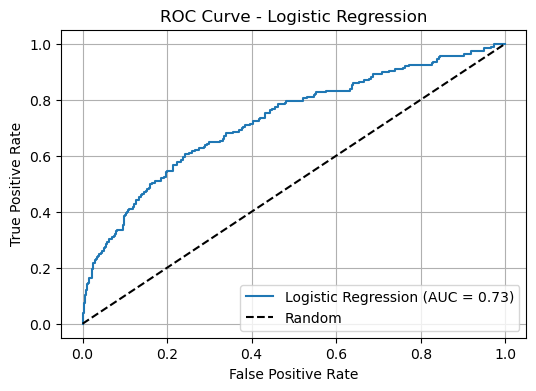

In [174]:
# Evaluate all models - Logistic Regression

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# custom ROC Curve 
def plot_custom_roc_curve(model, x_test, y_test, model_name="Model"):
    y_probs = model.predict_proba(x_test)[:, 1]
    false_positive_rate, true_positive_rate, _ = roc_curve(y_test, y_probs)
    roc_auc = auc(false_positive_rate, true_positive_rate)

    plt.figure(figsize=(6, 4))
    plt.plot(false_positive_rate, true_positive_rate, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()


plot_custom_roc_curve(lr_model, x_test, y_test, "Logistic Regression")




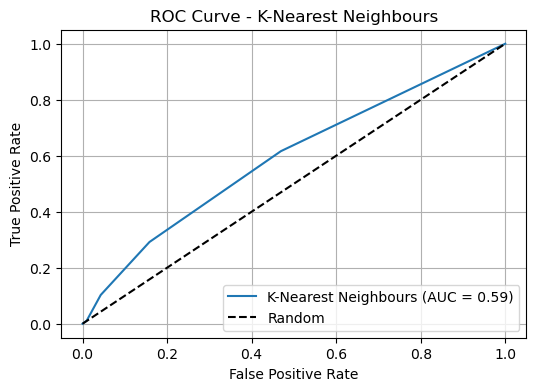

In [175]:
# Evaluate all models - KNN 
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=5)  
knn_model.fit(x_train, y_train)

plot_custom_roc_curve(knn_model, x_test, y_test, "K-Nearest Neighbours")


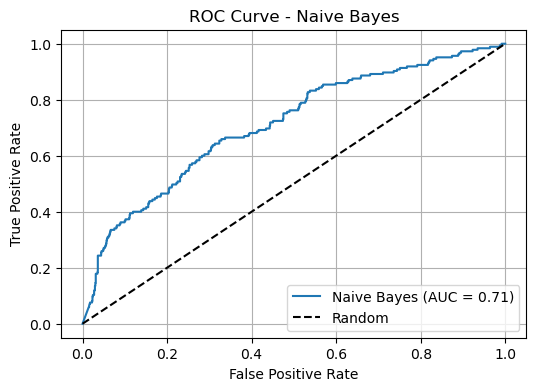

In [176]:
# Evaluate all models - Naive Bayes
from sklearn.naive_bayes import GaussianNB

nb_model = GaussianNB()
nb_model.fit(x_train, y_train)

plot_custom_roc_curve(nb_model, x_test, y_test, "Naive Bayes")


In [177]:
# model comparison
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def evaluate_model(name, model, x_test, y_test):
    y_pred = model.predict(x_test)
    y_proba = model.predict_proba(x_test)[:, 1]
    return {
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred),
        "AUC": roc_auc_score(y_test, y_proba)
    }

results = []

results.append(evaluate_model("Logistic Regression", lr_model, x_test, y_test))
results.append(evaluate_model("K-Nearest Neighbors", knn_model, x_test, y_test))
results.append(evaluate_model("Naive Bayes", nb_model, x_test, y_test))

import pandas as pd
results_df = pd.DataFrame(results)
print(results_df.sort_values(by="AUC", ascending=False))


                 Model  Accuracy  Precision    Recall  F1-Score       AUC
0  Logistic Regression  0.856788   0.676471  0.124324  0.210046  0.726443
2          Naive Bayes  0.792219   0.345794  0.400000  0.370927  0.711337
1  K-Nearest Neighbors  0.826159   0.301587  0.102703  0.153226  0.594777


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, recall_score, precision_score, f1_score

# Properly separated compatible combinations
param_grid = [
    # For liblinear: only l1 and l2 are supported
    {
        'solver': ['liblinear'],
        'penalty': ['l1', 'l2'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'class_weight': [None, 'balanced']
    },
    
    # For saga: supports l1, l2, elasticnet, and None (not 'none')
    {
        'solver': ['saga'],
        'penalty': ['l1', 'l2', 'elasticnet', None],  # Changed 'none' to None
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'class_weight': [None, 'balanced'],
        'l1_ratio': [0.5]  # Only used when penalty='elasticnet'
    }
]

# Create the grid search
grid_search = GridSearchCV(
    estimator=LogisticRegression(max_iter=5000),
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    error_score='raise'  # Add this to get detailed errors during fitting
)

# Fit the model
grid_search.fit(x_train, y_train)

# Output best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Score (F1):", grid_search.best_score_)

# Evaluate best model
best_log_reg = grid_search.best_estimator_
plot_custom_roc_curve(best_log_reg, x_test, y_test, "Tuned Logistic Regression")

# Predict and print metrics
y_pred = best_log_reg.predict(x_test)
y_prob = best_log_reg.predict_proba(x_test)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nKey Metrics:")
print(f"Recall: {recall_score(y_test, y_pred):.3f}")
print(f"Precision: {precision_score(y_test, y_pred):.3f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.3f}")

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklea

Confusion Matrix:
[[744 279]
 [ 67 118]]


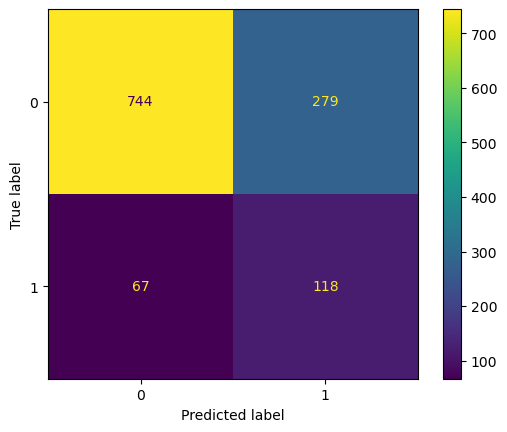

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming you have y_test and y_pred
cm = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Optional: Display it visually
confusion_metrix_visual = ConfusionMatrixDisplay(confusion_matrix=cm)
confusion_metrix_visual.plot()
